<a href="https://colab.research.google.com/github/Etharalshukairi/Ethar/blob/main/Plant%20Disease%20%20_classification_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
#My dataset is available in googledrive; so I am accessing my drive from colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#Once this is executed, you will see your drive appearing on the left hand side

Mounted at /content/drive


In [22]:
# Define paths to the dataset
train_dir = '/content/drive/MyDrive/train'  # Update with your actual path
test_dir = '/content/drive/MyDrive/test'    # Update with your actual path

In [25]:
import os
print(len(os.listdir('/content/drive/MyDrive/train/Healthy plant')))
print(len(os.listdir('/content/drive/MyDrive/train/Sick plant')))
print(len(os.listdir('/content/drive/MyDrive/test/Healthy plant')))
print(len(os.listdir('/content/drive/MyDrive/test/Sick plant')))

11
11
5
6


In [34]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Split 20% of the images for validation
)

# Load and prepare training data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',  # 'binary' for binary classification (cats vs. dogs)
    subset='training'  # Specify 'training' for the training set
)

# Create ImageDataGenerator for validation set
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Note: Using the same validation split as in the training set
)

# Load and prepare validation data
validation_data = validation_datagen.flow_from_directory(
    train_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Specify 'validation' for the validation set
)

Found 18 images belonging to 3 classes.
Found 4 images belonging to 3 classes.


In [33]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten

resnet_model = Sequential()    #ResNet50 is a pre-trained model
pretrained_model = tf.keras.applications.ResNet50(include_top = False, #because i have my own image of a diff dimension
                                                input_shape = (256,256,3),
                                                pooling = 'max', classes = 2,
                                                weights = 'imagenet')
for layer in pretrained_model.layers:
    layer.trainable = False  #all layers in the Resnet50 is not trainable; keep those weights; I am going to add my own i/p and other layers

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation = 'relu'))
resnet_model.add(Dense(1, activation = 'sigmoid'))

In [32]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24,637,313
Trainable params: 1,049,601
Non-trainable params: 23,587,712
_________________________________________________________________


In [31]:
from keras.optimizers import Adam
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy']) #binary_crossentropy - binary classification

In [28]:
history = resnet_model.fit(train_data, epochs=3, validation_data=validation_data)

Epoch 1/3
1/1 [==============================] - 11s 11s/step - loss: -23.2813 - accuracy: 0.5000 - val_loss: -30.5595 - val_accuracy: 0.5000
Epoch 2/3
1/1 [==============================] - 6s 6s/step - loss: -30.6816 - accuracy: 0.5000 - val_loss: -37.9474 - val_accuracy: 0.5000
Epoch 3/3
1/1 [==============================] - 5s 5s/step - loss: -38.1086 - accuracy: 0.5000 - val_loss: -45.5543 - val_accuracy: 0.5000


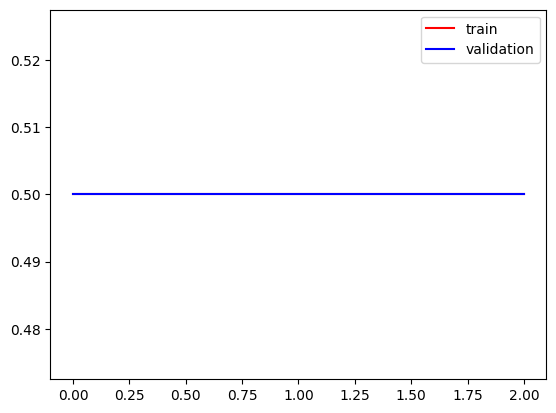

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

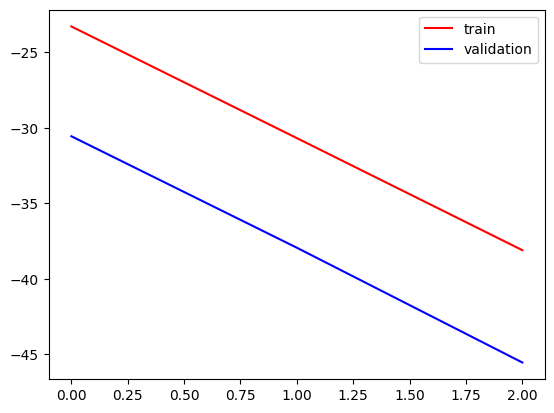

In [35]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [36]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256,256),
    batch_size=32,
    class_mode='binary'
)

Found 11 images belonging to 3 classes.


In [37]:
#predict the test data
predictions = resnet_model.predict(test_data)
print(predictions)

1/1 [==============================] - 5s 5s/step
[[0.10984889]
 [0.10455796]
 [0.17981914]
 [0.16716687]
 [0.07708392]
 [0.13179432]
 [0.4693534 ]
 [0.12914887]
 [0.09549006]
 [0.1175948 ]
 [0.21879834]]


In [38]:
len(predictions)

11

In [39]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have ground truth labels (true_labels) and predicted labels (predictions)
true_labels = test_data.classes
predicted_labels = (predictions > 0.5).astype(int)  # Adjust the threshold as needed

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

Confusion Matrix:
[[0 0 0]
 [5 0 0]
 [6 0 0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       5.0
           2       0.00      0.00      0.00       6.0

    accuracy                           0.00      11.0
   macro avg       0.00      0.00      0.00      11.0
weighted avg       0.00      0.00      0.00      11.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.